In [326]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer

# EXAMEN

## EJERCICIO 1

Carga el conjunto de datos Iris (el de las flores según la anchura y la altura del pétalo y del sépalo) desde scikit-learn (se ha hecho en algún ejercicio).

Explora los datos visualmente utilizando gráficos: representa la distribución de cada variable (todas las de X e y), diagramas de cajas de cada variable (todas las de X) y la matriz de correlaciones para entender las relaciones entre las características. ¿Qué puedes deducir?

Divide el conjunto de datos en entrenamiento y prueba, estratificando por el tipo de flor.

Prepara los datos mediante una pipeline.

Entrena y evalúa un clasificador Random Forest utilizando validación cruzada. ¿Qué métrica has usado para evaluar el modelo y por qué? ¿Cuál es el mejor y el peor error que consigues?

Optimiza el número de árboles, ¿cuál es el mejor valor?

Evalúa el rendimiento del modelo optimizado en el conjunto de prueba.

Guarda el modelo en un fichero y cárgalo desde un fichero .py que pida 4 datos para una nueva flor (anchura del pétalo, longitud del pétalo, anchura del sépalo y longitud del sépalo) y prediga de que clase es la flor (quiero que me de un nombre, no un número y hay que controlar las excepciones).

In [327]:
# Cargamos los datos del conjunto iris y los dividimos en características y target
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

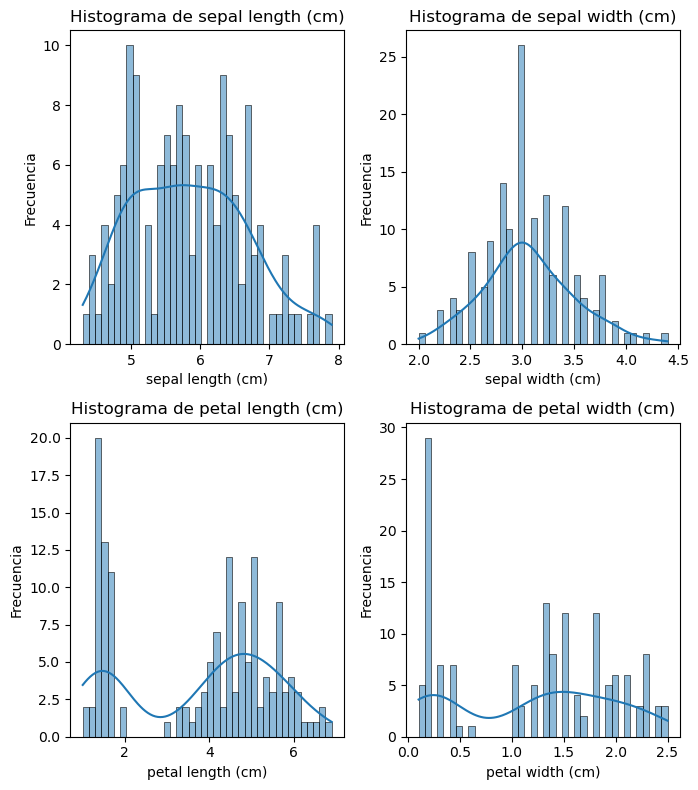

In [328]:
# Mostramos gráficamente las características

# Crear la cuadrícula de subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(7, 8))  # Tamaño de la figura ajustado
axes = axes.flatten()  # Aplanar el arreglo de ejes para un acceso más fácil

# Índice para los subplots
idx = 0

# Graficar las variables numéricas
for columna in X.columns:
    if idx < len(axes):  # Verificar si el índice está dentro del rango de subplots
        sns.histplot(data=X, x=columna, bins=40, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Histograma de {columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

# Eliminar cualquier subplot no utilizado
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

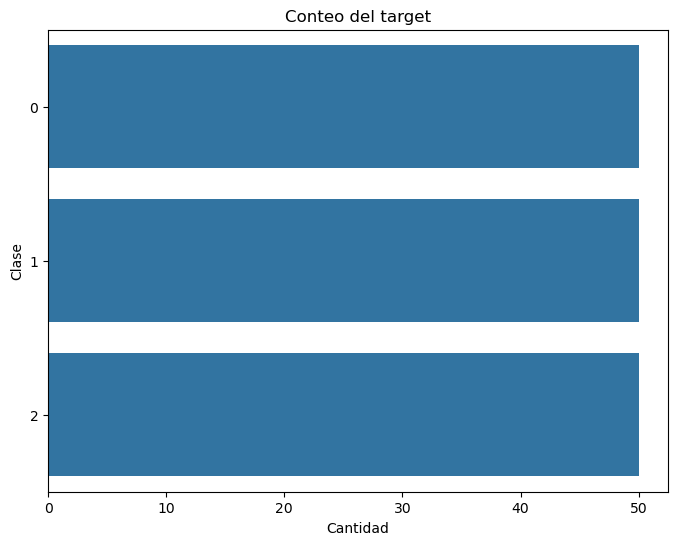

In [329]:
# Sacamos gráfica de los target
temp = pd.DataFrame(y)
temp.head()

# Crear el histograma con seaborn
plt.figure(figsize=(8, 6))
sns.countplot(temp, y="target")

# Etiquetas
plt.title('Conteo del target')
plt.xlabel('Cantidad')
plt.ylabel('Clase')

# Mostrar el histograma
plt.show()

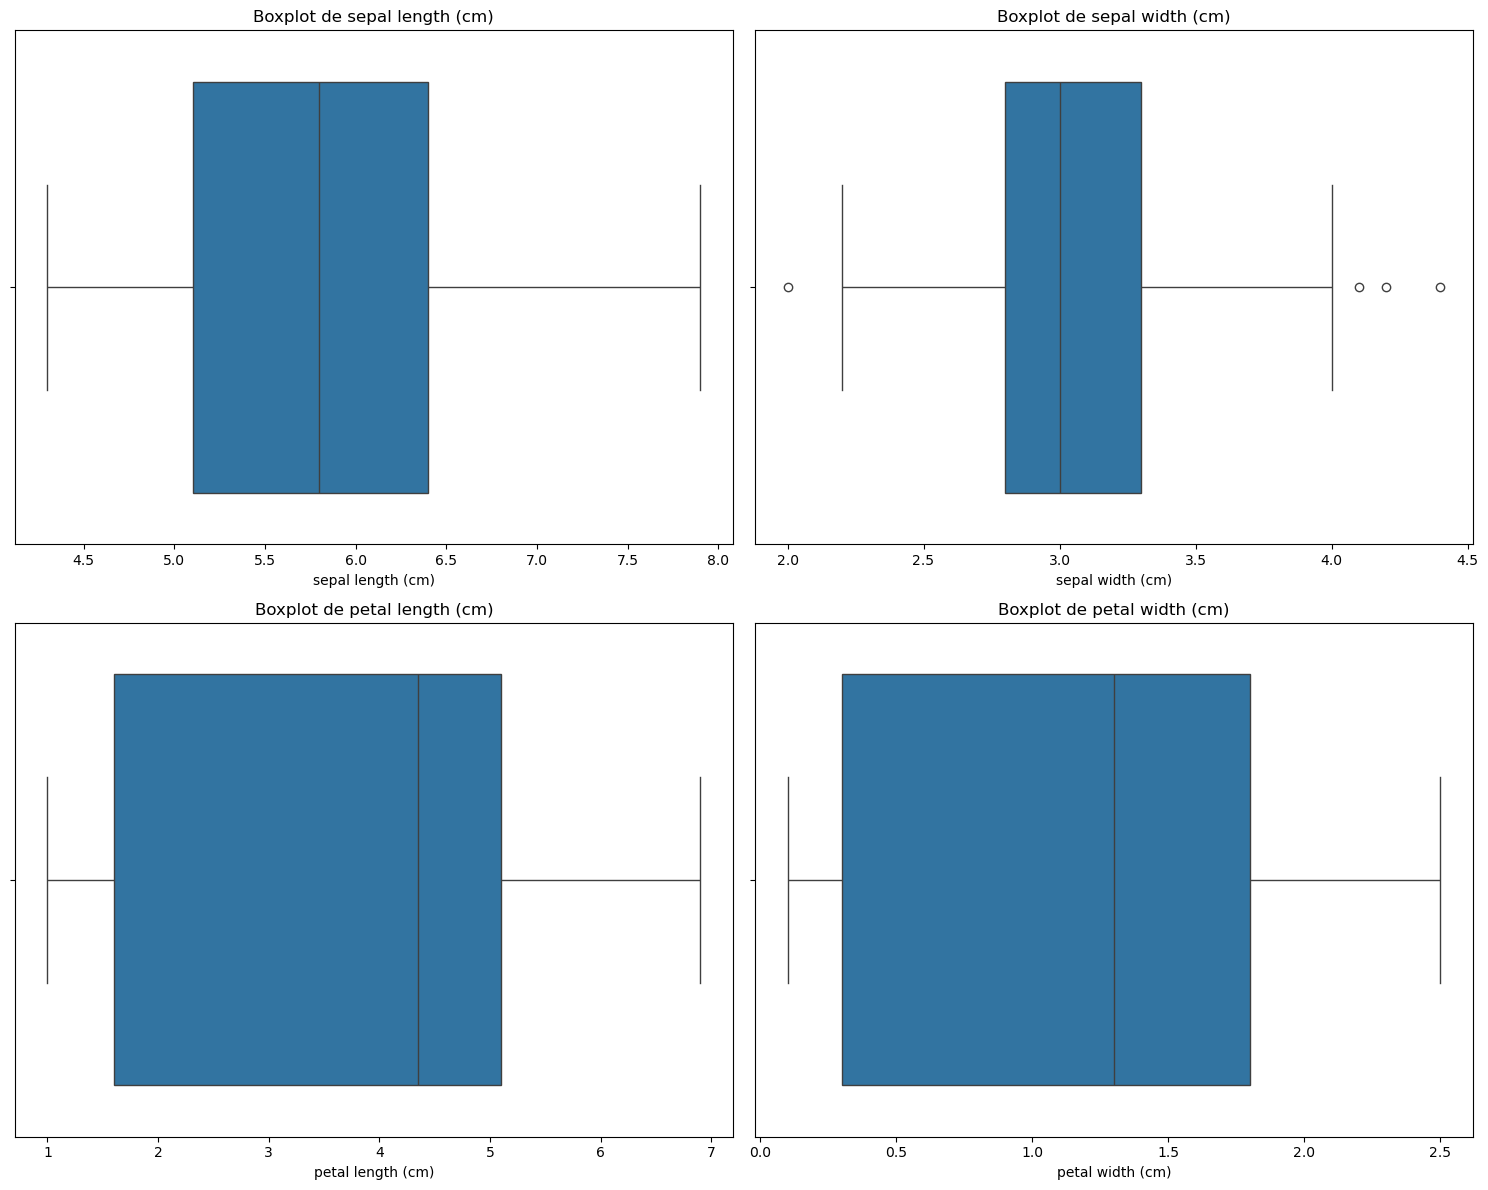

In [330]:
# Sacamos boxplots de las características

# Seleccionar las columnas numéricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Definir el tamaño de la cuadrícula
nrows = 2
ncols = 2

# Crear subgráficos
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))

# Aplanar la matriz de ejes para poder iterar fácilmente
axes = axes.flatten()

# Crear boxplots para las columnas numéricas
for i in range(len(num_cols)):
    sns.boxplot(data=X, x=num_cols[i], ax=axes[i])
    axes[i].set_title(f"Boxplot de {num_cols[i]}")

# Ajustar la disposición de los subgráficos para que no se superpongan
plt.tight_layout()

# Mostrar los boxplots
plt.show()


In [331]:
# Hacemos copia temporal para unir caracteristicas y target
temp = X.copy()
temp["clase"] = y

# Sacamos matriz de correlacion
corr_matrix = temp.corr(numeric_only=True)
corr_matrix.style.background_gradient()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),clase
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
clase,0.782561,-0.426658,0.949035,0.956547,1.000000


In [ ]:
# Parece que la longitud y ancho de los pétalos está fuertemente correlacionado con la clase
# de iris, mientras que la longitud y sobretodo la anchura del sépalo es menos diferenciable.
# No obstante todos los datos tienen bastante correlación con la clase y por tanto deberían de ser
# útiles a la hora de entrenar el modelo.


In [333]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba estratificando por el tipo de flor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [334]:
# Creamos una pipeline para aplicar a los datos antes de entrenar el modelo
pipeline = make_pipeline(StandardScaler())
pipeline.fit_transform(X_train,y_train)

array([[-1.72156775, -0.33210111, -1.34572231, -1.32327558],
       [-1.12449223, -1.22765467,  0.41450518,  0.6517626 ],
       [ 1.14439475, -0.5559895 ,  0.58484978,  0.25675496],
       [-1.12449223,  0.11567567, -1.28894078, -1.45494479],
       [-0.40800161, -1.22765467,  0.13059752,  0.12508575],
       [ 0.54731923, -1.22765467,  0.69841284,  0.91510102],
       [-0.2885865 , -0.77987789,  0.24416059,  0.12508575],
       [ 0.54731923, -0.5559895 ,  0.75519438,  0.38842418],
       [ 2.21913069, -0.10821272,  1.3230097 ,  1.44177787],
       [ 2.21913069,  1.6828944 ,  1.66369889,  1.31010866],
       [ 2.09971558, -0.10821272,  1.60691736,  1.17843945],
       [ 0.18907392, -0.33210111,  0.41450518,  0.38842418],
       [-1.00507713, -2.34709662, -0.15331014, -0.26992188],
       [-0.04975629, -0.77987789,  0.18737906, -0.26992188],
       [-0.04975629, -1.00376628,  0.13059752, -0.00658346],
       [-1.36332244,  0.33956406, -1.23215924, -1.32327558],
       [-0.88566202,  1.

In [335]:
# Creamos el modelo
rdm_forest = RandomForestClassifier(random_state=42)

# Evaluación cruzada
y_train_score = cross_val_score(rdm_forest, X_train, y_train, cv=5, scoring="f1_micro")
print(f"Error máximo: {min(y_train_score)}, error mínimo: {max(y_train_score)}")

Error máximo: 0.9166666666666666, error mínimo: 0.9583333333333334


In [ ]:
# He usado f1_micro como sistema de evaluación debido a que es la métrica más completa
# dandonos la media harmónica de precisión y sensibilidad. He usado la opción micro que devuelve el cómputo
# global dado a que nuestros datos vienen preparados y todas las clases tienen la misma cantidad de filas

In [337]:
# Crear diccionario con parámetros
param_grid = {
    'n_estimators': [50,100,150,200],               # Número de árboles
    'random_state': [42]                            # Fijar la semilla para reproducibilidad
}

# Configurar la búsqueda en rejilla
grid_search = GridSearchCV(
    estimator=rdm_forest,
    param_grid=param_grid,   # Usamos param_grid en lugar de param_distributions
    scoring="f1_micro",      # Métrica de evaluación
    cv=5,                    # Validación cruzada con 5 folds
    verbose=1,               # Mostrar progreso
    n_jobs=-1,               # Usar todos los núcleos disponibles
)

# Realizar la búsqueda en rejilla en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros: {'n_estimators': 50, 'random_state': 42}


In [338]:
# Preparar el mejor modelo
best_model = grid_search.best_estimator_

# Transformar el conjunto de prueba
pipeline.fit_transform(X_test,y_test)

# Evaluación cruzada
y_test_score = cross_val_score(best_model, X_test, y_test, cv=5, scoring="f1_micro")
print(f"Error máximo: {min(y_test_score)}, error mínimo: {max(y_test_score)}")

Error máximo: 0.8333333333333334, error mínimo: 1.0


In [339]:
# Exportamos el modelo
joblib.dump(best_model, "./Examen1_Iris.pkl")

['./Examen1_Iris.pkl']

## EJERCICIO 2

En este ejercicio, trabajarás con un conjunto de datos de pruebas creados (ejercicio2.csv). 

Tu objetivo es construir un modelo de regresión que pueda predecir con precisión la variable dependiente y a partir de las variables independientes x1 y x2. 

Deberás:
* Cargar los datos
* Visualizar gráficamente los datos (x1 respecto a y e x2 respecto a y)
* Dividir los datos en conjunto de entrenamiento y pruebas
* Probar diferentes modelos de regresión polinómica (PolynomialFeatures + ), hasta ver cuál es el mejor degree (y explicarlo gráficamente y por medida del error en los conjuntos de entrenamiento y pruebas), no hace falta que uses validación cruzada. ¿Qué medición has usado para evaluar el modelo y por qué? ¿cuál es el mejor degree?
* Probar ahora con Elastic Net, optimizando los hiperparámetros con búsqueda exhaustiva, ¿ha mejorado con esta regularización? ¿cuáles son los mejores datos para los hiperparámetros?

Pista para hacer la gráfica:

´´´´´´

    degrees = [1, 2, 3, 4, 5]
    train_errors = []
    test_errors = []

    for degree in degrees:
        model = Pipeline([
            XXX
        ])
        model.fit(XXX)

        y_train_pred = model.predict(XXX)
        y_test_pred = model.predict(XXX)
        train_error= XXX #medir el error en el conjunto de entrenamiento
        test_error= XXX #medir el error en el conjunto de test
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_errors, label='Train Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs. Degree of Polynomial')
    plt.legend()
    plt.show()

´´´´´´

In [340]:
# Leemos los datos
df = pd.read_csv('./ejercicio2.csv')
df.head()

,x1,x2,y
0,0.488135,3.115185,-91.197936
1,2.151894,-0.239160,-44.928270
2,1.027634,0.231560,-5.347793
3,0.448832,-2.494794,78.026649
4,-0.763452,1.050430,2.176875


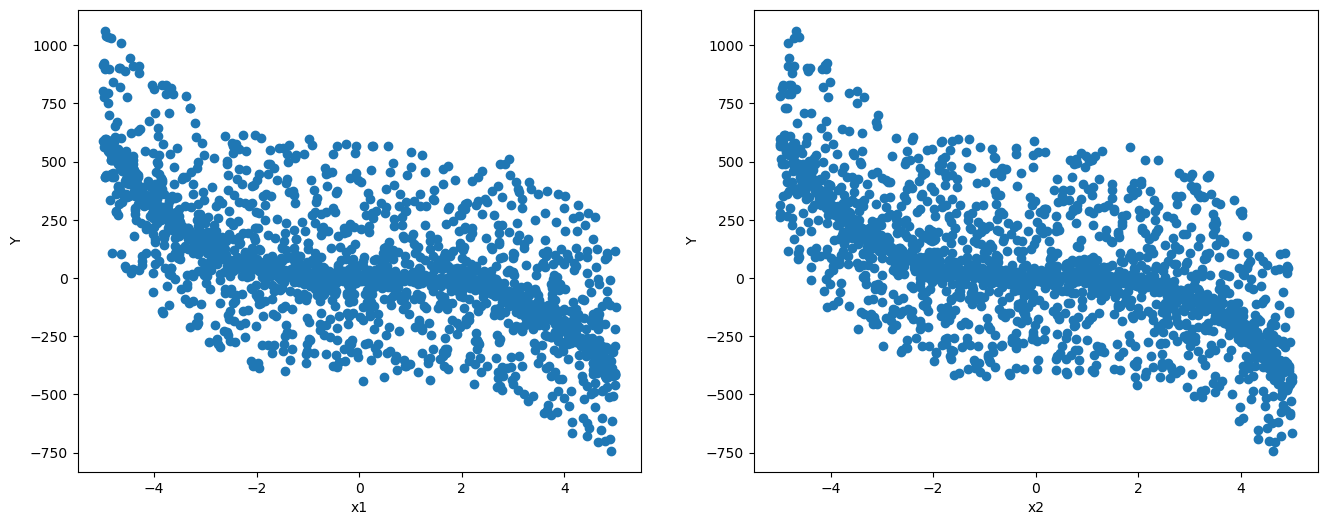

In [341]:
# Representamos los datos

# Visualizar los puntos en un gráfico 3D
fig = plt.figure(figsize=(16, 6))  # Ajustar el tamaño de la figura
ax = fig.add_subplot(121)
ax.scatter(df["x1"], df["y"])
ax.set_xlabel("x1")
ax.set_ylabel("Y")

# Visualizar la proyección 2D utilizando PCA
ax2 = fig.add_subplot(122)
ax2.scatter(df["x2"], df["y"])
ax2.set_xlabel("x2")
ax2.set_ylabel("Y")

plt.show()

In [342]:
# Dividimos los datos
X = df.drop("y",axis=1)
y = df["y"]

# Creamos los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Grado: 1, error entrenamiento:113.1529401826091 , error test: 108.91220965965277
Grado: 2, error entrenamiento:107.76582805737768 , error test: 107.37403063517353
Grado: 3, error entrenamiento:9.990328858937339 , error test: 10.373008186794973
Grado: 4, error entrenamiento:9.980148252895184 , error test: 10.349780872532953
Grado: 5, error entrenamiento:9.973507409100522 , error test: 10.35331312418184


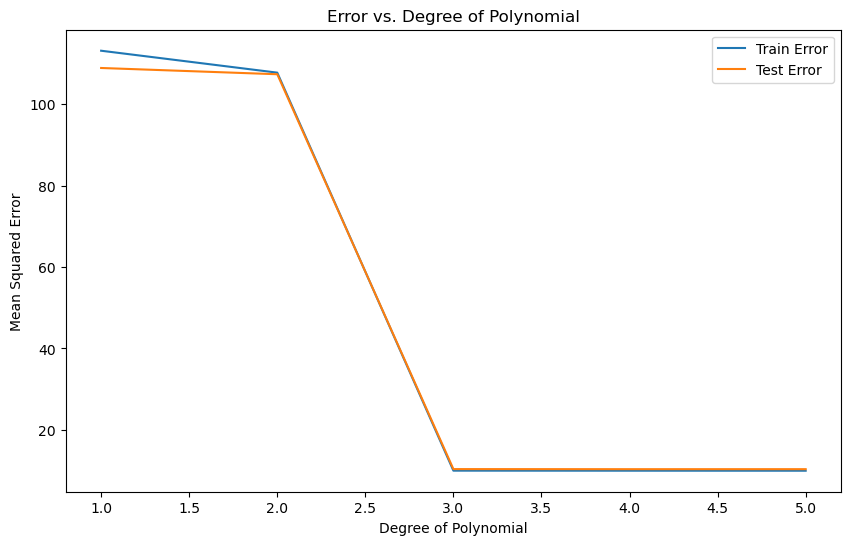

In [343]:
# Creamos el bucle para probar polinomios

degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []

for degree in degrees:
    model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        LinearRegression()
    )
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error= np.sqrt(mean_squared_error(y_train, y_train_pred)) #medir el error en el conjunto de entrenamiento
    test_error= np.sqrt(mean_squared_error(y_test, y_test_pred)) #medir el error en el conjunto de test
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()

In [ ]:
# He usado el RMSE dado a que nos devuelve un error a escala de los datos que tenemos y nos permite
# ver por cuánto está fallando nuestro modelo.
# El mejor degree parece ser a partir del 3, hasta el 5 no parece haber overfitting, pero con un
# polinomio mayor podría haber más error en el conjunto de evaluación


In [345]:
# Modelo y pipeline
model = make_pipeline(
        PolynomialFeatures(degree=3, include_bias=False), # Sabemos que 3 va bien
        StandardScaler(),
        ElasticNet()
    )

# Parámetros a buscar
param_grid = {
    'elasticnet__alpha': [0.1,0.25,0.75,1],
    'elasticnet__l1_ratio':[0.1,0.25,0.75,1]
}

# Configurar la búsqueda en rejilla
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,                          # Usamos param_grid en lugar de param_distributions
    scoring="neg_root_mean_squared_error",          # Métrica de evaluación
    cv=3,                                           # Validación cruzada con 5 folds
    verbose=1,                                      # Mostrar progreso
    n_jobs=-1,                                      # Usar todos los núcleos disponibles
)

# Realizar la búsqueda en rejilla en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_error= np.sqrt(mean_squared_error(y_train, y_train_pred)) #medir el error en el conjunto de entrenamiento
test_error= np.sqrt(mean_squared_error(y_test, y_test_pred)) #medir el error en el conjunto de test

print(f"Error entrenamiento: {train_error}")
print(f"Error test: {test_error}")

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Error entrenamiento: 9.992641462136126
Error test: 10.37142474177792
Mejores hiperparámetros: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 1}


In [ ]:
# Ha habido una empeoría ínfima en el grupo de entrenamiento y una mejoría ínfima en el grupo de test

## EJERCICIO 3

Queremos predecir la calidad del vino (quality) a partir del resto de características.

Carga el conjunto de datos winequality.csv, explora los datos y divide el conjunto de datos en entrenamiento y pruebas (10% para las pruebas).

Crea una pipeline para preparar los datos y aplicar un algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Crea una pipeline para preparar los datos y aplicar PCA que explique al menos el 95% de la varianza, aplica esta pipeline al conjunto de entrenamiento y al conjunto de pruebas.

Muestra cuantas dimensiones tenías al principio y cuantas después de aplicar PCA.

Aplica a los datos obtenido de aplicar PCA el algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Compara el error y el tiempo empleado en los dos modelos (sin pca y con pca) e interpreta el resultado.


In [347]:
# Cargamos los datos, ojo con el separador (;) en vez de (,)
df = pd.read_csv("./winequality.csv", sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [348]:
# Miramos datos estadísticos
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [349]:
# Miramos valores nulos y tipos de fila
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


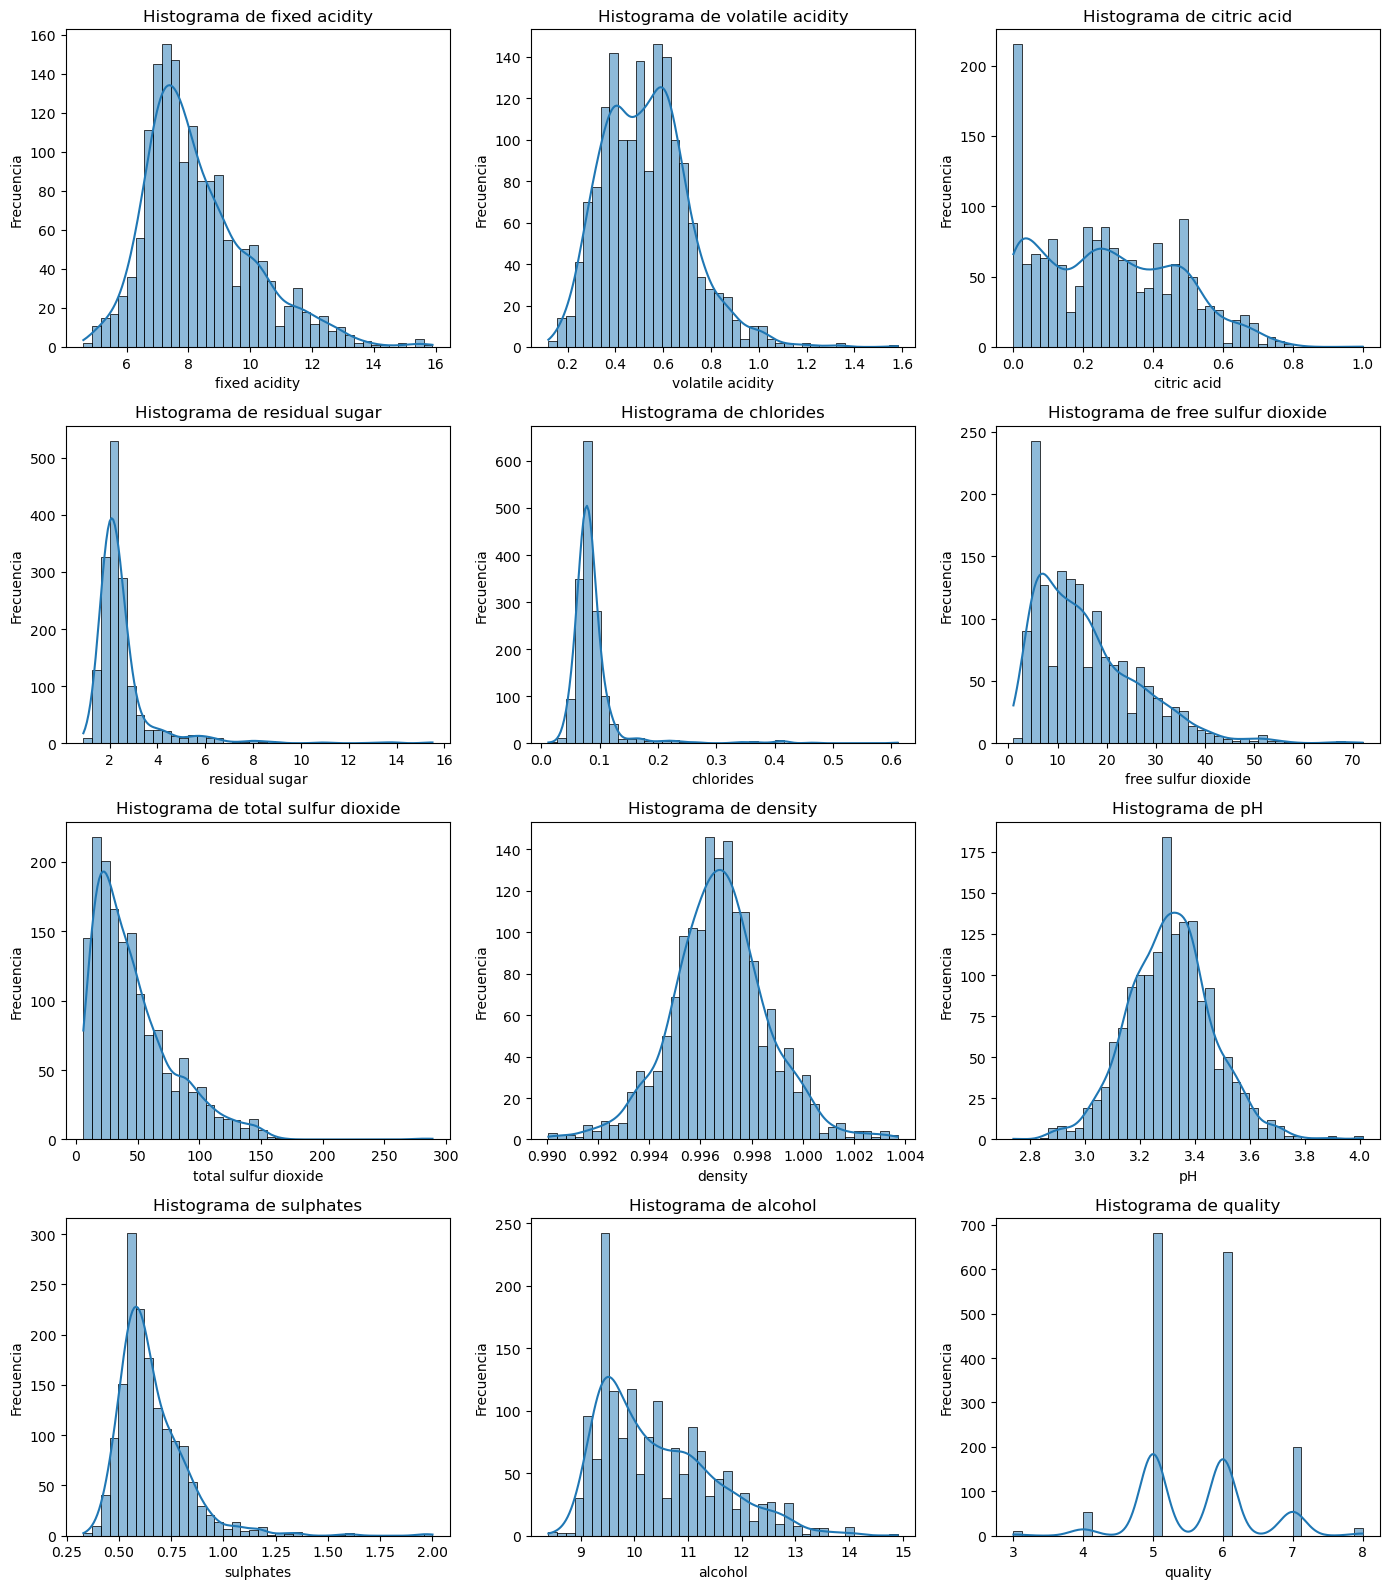

In [350]:
# Sacamos gráficos

# Crear la cuadrícula de subplots 4x3
fig, axes = plt.subplots(4, 3, figsize=(14, 16))  # Tamaño de la figura ajustado
axes = axes.flatten()  # Aplanar el arreglo de ejes para un acceso más fácil

# Índice para los subplots
idx = 0

# Graficar las variables numéricas
for columna in df.columns:
    if idx < len(axes):  # Verificar si el índice está dentro del rango de subplots
        sns.histplot(data=df, x=columna, bins=40, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Histograma de {columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

# Eliminar cualquier subplot no utilizado
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

In [351]:
# Sacamos matriz de correlacion
corr_matrix = df.corr(numeric_only=True)
corr_matrix.style.background_gradient()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [352]:
# Dividimos los datos en sus conjuntos
X = df.drop("quality",axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [353]:
# Pipeline sin PCA
normal_pipeline = make_pipeline(
    StandardScaler(),
    SVC(random_state=42)
)

%time normal_pipeline.fit(X_train,y_train)

CPU times: user 97.2 ms, sys: 42 μs, total: 97.3 ms
Wall time: 96.9 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [354]:
# Sacar la exactitud (no tengo importado otra métrica sin cross_val)
y_test_pred = normal_pipeline.predict(X_test)
y_test_score = accuracy_score(y_test_pred,y_test)
print(y_test_score)

0.6


In [355]:
# Pipeline PCA
pca_pipeline = make_pipeline(
    PCA(n_components=0.95)
)

# Transformar datos
X_train_reduced = pca_pipeline.fit_transform(X_train)
X_test_reduced = pca_pipeline.transform(X_test)

print(f"Dimensiones antes: {X_train.shape}, dimensiones ahora: {X_train_reduced.shape}")

Dimensiones antes: (1439, 11), dimensiones ahora: (1439, 2)


In [356]:
pipeline = make_pipeline(
    StandardScaler(),
    SVC(random_state=42)
)

%time pipeline.fit(X_train_reduced,y_train)

CPU times: user 666 ms, sys: 11.6 ms, total: 678 ms
Wall time: 170 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [357]:
y_test_pred = pipeline.predict(X_test_reduced)
y_test_score = accuracy_score(y_test_pred,y_test)
print(y_test_score)

0.525


In [ ]:
# Ha tardado más tiempo (12 milesimas al ser un conjunto relativamente pequeño) y encima ha empeorado
# su precisión en un 7,5%. Parece que PCA no ayuda a la hora de usar un modelo SVC probablemente porque
# las modificaciones realizadas a las columnas ni agilicen al SVC la interpretación de datos ni le ayuden
# a sacar conclusiones

'\nHa tardado más tiempo (12 milesimas al ser un conjunto relativamente pequeño) y encima ha empeorado\nsu precisión en un 7,5%. Parece que PCA no ayuda a la hora de usar un modelo SVC probablemente porque\nlas modificaciones realizadas a las columnas ni agilicen al SVC la interpretación de datos ni le ayuden\na sacar conclusiones\n'

In [359]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1125,8.8,0.240,0.35,1.7,0.055,13.0,27.0,0.99394,3.14,0.59,11.3
1144,7.3,0.320,0.23,2.3,0.066,35.0,70.0,0.99588,3.43,0.62,10.1
1058,9.9,0.530,0.57,2.4,0.093,30.0,52.0,0.99710,3.19,0.76,11.6
629,7.6,0.685,0.23,2.3,0.111,20.0,84.0,0.99640,3.21,0.61,9.3
1350,9.0,0.600,0.29,2.0,0.069,32.0,73.0,0.99654,3.34,0.57,10.0


In [360]:
X_train_reduced[0]

array([-19.97544011,   1.40108429])

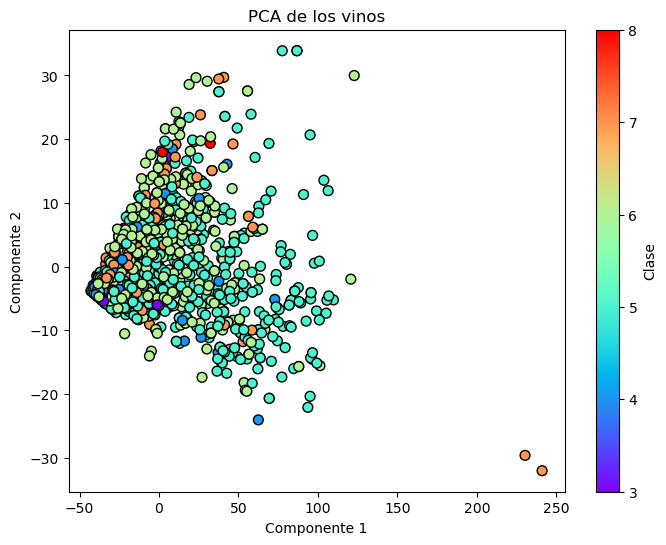

In [361]:
# Graficar los datos en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train.astype(int), cmap='rainbow', edgecolor='k', s=50)

# Añadir una barra de color que muestre las clases
plt.colorbar(scatter, label='Clase')

# Títulos y etiquetas
plt.title('PCA de los vinos')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

# Mostrar el gráfico
plt.show()

In [380]:
# Al representarlos en un gráfico, dado a que PCA al 95% de varianza ha decidido reducirlo a dos dimensiones,
# podemos ver como las calidades de vino están bastante mezcladas e incluso que hay varios outliers.

## EJERCICIO 4

Una empresa de coches ha sacado un nuevo modelo al mercado. Le ha preguntado a una red social quién ha comprado el producto, recaudando el sexo, la edad y el salario de cada uno de ellos. Ahora queremos construir un modelo que nos permita determinar con estos atributos si la persona comprará el producto o no, para tomar medidas en función de la respuesta para que lo acabe comprando.

Los datos están en el csv

### RECOPILACIÓN Y RECOLECCIÓN DE LOS DATOS

####  OBTENER LOS DATOS

In [363]:
df = pd.read_csv("./compras.csv")
df.head()

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0


#### EXPLORAR LOS DATOS 
Con exhaustividad: datos estadísticos, gráficos, correlaciones... e indicar las deduciones a las que llegas

In [364]:
df.info() # Parece que no hay valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Identificador  400 non-null    int64 
 1   Sexo           400 non-null    object
 2   Edad           400 non-null    int64 
 3   Salario        400 non-null    int64 
 4   Compra         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [365]:
df["Identificador"].value_counts() # Los IDs son todos únicos y no nos dan nada de información

Identificador
15624510    1
15767681    1
15589449    1
15791373    1
15688172    1
           ..
15675185    1
15792102    1
15722758    1
15745232    1
15594041    1
Name: count, Length: 400, dtype: int64

In [366]:
df.drop("Identificador",axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Sexo     400 non-null    object
 1   Edad     400 non-null    int64 
 2   Salario  400 non-null    int64 
 3   Compra   400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


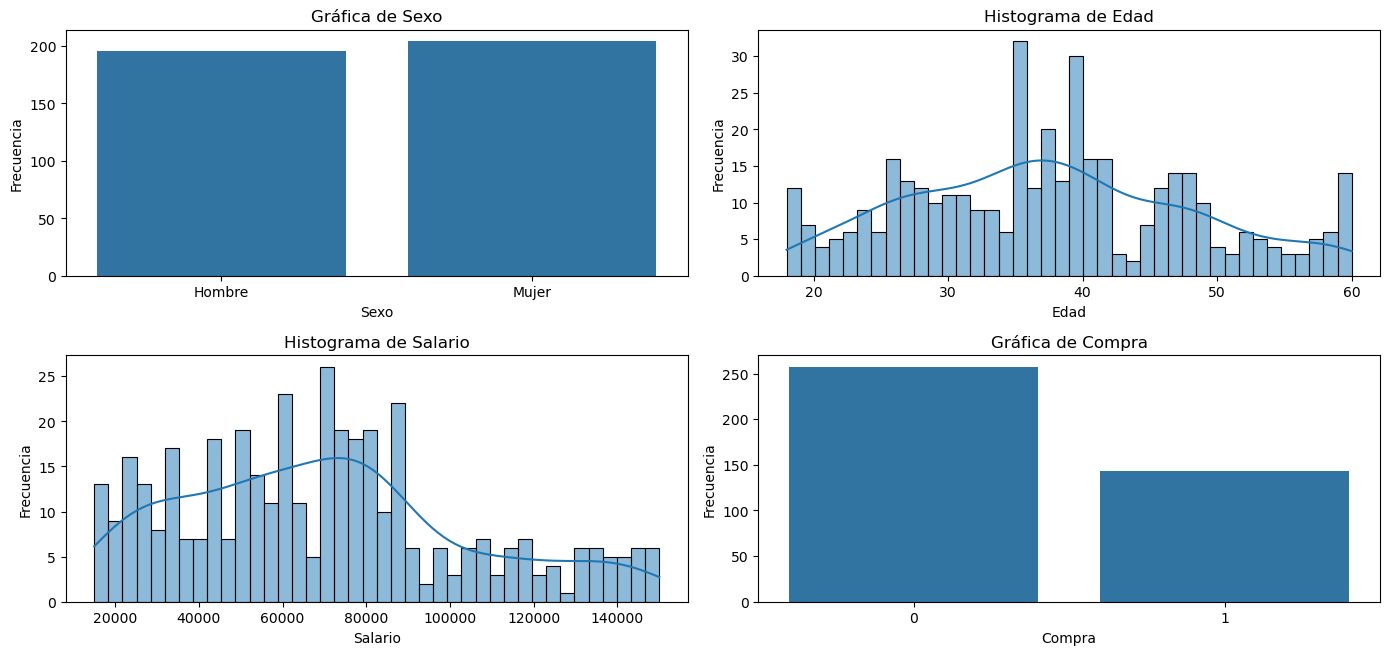

In [367]:
# Crear la cuadrícula de subplots 5x2
fig, axes = plt.subplots(5, 2, figsize=(14, 16))  # Tamaño de la figura ajustado
axes = axes.flatten()  # Aplanar el arreglo de ejes para un acceso más fácil

# Índice para los subplots
idx = 0

# Graficar las variables numéricas
for columna in df.columns:
    if idx < len(axes):  # Verificar si el índice está dentro del rango de subplots
        if columna != "Sexo" and columna != "Compra":
            sns.histplot(data=df, x=columna, bins=40, kde=True, ax=axes[idx])
            axes[idx].set_title(f'Histograma de {columna}')
            axes[idx].set_xlabel(columna)
            axes[idx].set_ylabel('Frecuencia')
            idx += 1
        else:
            sns.countplot(data=df, x=columna, ax=axes[idx])
            axes[idx].set_title(f'Gráfica de {columna}')
            axes[idx].set_xlabel(columna)
            axes[idx].set_ylabel('Frecuencia')
            idx += 1

# Eliminar cualquier subplot no utilizado
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

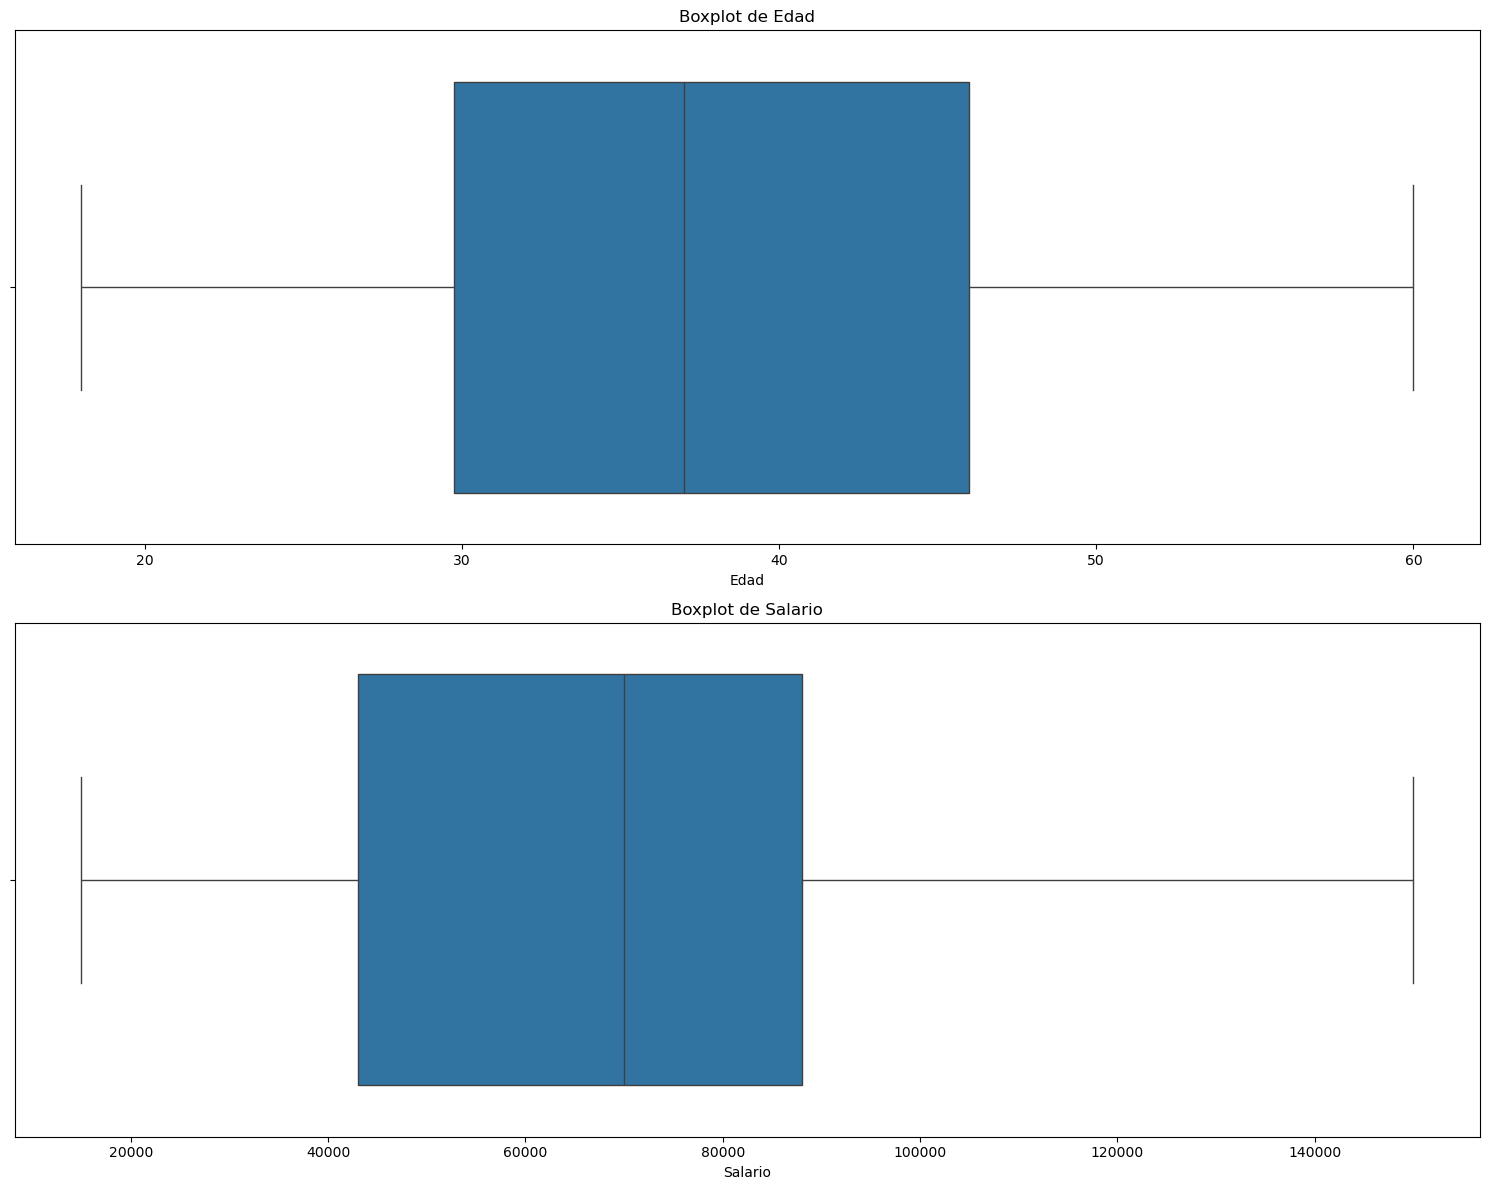

In [368]:
# Sacamos boxplots de las características

# Seleccionar las columnas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Crear subgráficos
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Aplanar la matriz de ejes para poder iterar fácilmente
axes = axes.flatten()

# Crear boxplots para las columnas numéricas
for i in range(len(num_cols)):
    if num_cols[i] == "Compra":
        pass
    else:
        sns.boxplot(data=df, x=num_cols[i], ax=axes[i])
        axes[i].set_title(f"Boxplot de {num_cols[i]}")

# Ajustar la disposición de los subgráficos para que no se superpongan
plt.tight_layout()

# Mostrar los boxplots
plt.show()

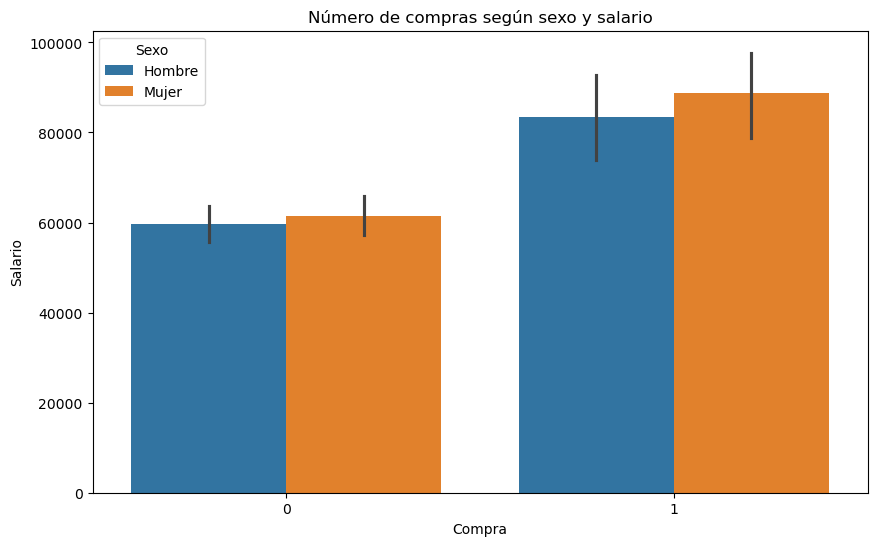

In [369]:
# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Compra', y='Salario', hue='Sexo')

# Añadir títulos y etiquetas
plt.title('Número de compras según sexo y salario')
plt.xlabel('Compra')
plt.ylabel('Salario')
plt.legend(title='Sexo')

# Mostrar el gráfico
plt.show()

In [382]:
# Parece que el salario influye a la hora de comprar el coche y que las mujeres tienen un salario
# medio superior a los hombres

In [371]:
# Sacamos matriz de correlacion
corr_matrix = df.corr(numeric_only=True)
corr_matrix.style.background_gradient()

,Edad,Salario,Compra
Edad,1.000000,0.155238,0.622454
Salario,0.155238,1.000000,0.362083
Compra,0.622454,0.362083,1.000000


In [381]:
# La matriz de correlación muestra que la edad influye más a la hora de comprar,
# aunque no puede calcular la correlación con el sexo del comprador

In [383]:
# Conclusiones:
# Podemos descartar la columna Identificador dado a que no nos da valor alguno.
# Hay un buen balance de muestras en general.
# No hay outliers en las variables numéricas.
# Las mujeres son las que más coches han comprado.
# La gente mayor compra más coches.
# La gente con mayor salario compra más coches.
# Hay más correlación con la edad que con el salario a la hora de comprar.

#### DIVIDIR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [374]:
X = df.drop("Compra", axis=1)
y= df["Compra"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### PREPARAR LOS DATOS
Algunas pistas a tener en cuenta (** esto no quiere decir que sólo haya que hacer esto**):
* No usar las características que no sirven
* Tratar los valores nulos (aunque ahora no haya)
* Edad: primeramente convertir en categórica poniendo las siguientes etiquetas y luego aplicar el cambio que procede en las variables categóricas (es para aplicar los diferentes tipos de transformaciones que hay, no porque tenga mucho sentido).
  * 0-20 --> Rango1
  * 20-30 --> Rango 2
  * 30-40 --> Rango 3
  * 40-50 --> Rango 4
  * 50- --> Rango 5

* Salario: aplicar logaritmo (aunque no tenga una cola larga a la derecha) y luego estandarizar

In [375]:
sexo_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
)

edad_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    pd.cut(df['Edad'], bins=[-1,20,30,40,50,np.inf], labels=["Rango 1","Rango 2","Rango 3","Rango 4","Rango 5"], right=False),
    OneHotEncoder()
)

salario_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    np.log(df['Salario']),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("Sexo",sexo_pipeline,["Sexo"]),
    ("Edad",edad_pipeline,["Edad"]),
    ("Salario",salario_pipeline,["Salario"]),
],
remainder='drop' # Ignorar Identificador
)